# XRay Hand Detection using Tensorflow

## Label Preprocessing

In [2]:

import os
import cv2
import numpy as np

folder_path = 'XRay_JointDetection/Dataset/'
process_files = os.listdir(folder_path)

image_file_paths = []
labels = []
for file in process_files:
    file_path = folder_path+file
    if os.path.isfile(file_path):
        try:
            img = cv2.imread(file_path)
            image_x, image_y, _ = img.shape
            temp_label = []
            with open(f'XRay_Detection/Labels/txt/{file[:-4]}_v06.txt', 'r') as fil:                
                image_file_paths += [file_path]
                lis = fil.readlines()[1:]
                x_lis = []
                y_lis = []
                r_lis = []
                for line in lis:
                    x, y, r = tuple(map(lambda x: float(x), line[:-1].split(' ')[1:]))
                    x_lis+=[x/image_x]
                    y_lis+=[y/image_y]
                    r_lis+=[r]
            temp_label+=[x_lis, y_lis, r_lis]
            labels+=[temp_label]
        except Exception as e:
            pass
labels = np.array(labels)

In [3]:
import numpy as np
labels = np.array(labels)

In [4]:
image_file_paths = np.array(image_file_paths).reshape((-1,1))
image_file_paths.shape

(2473, 1)

In [5]:
labels.shape

(2473, 3, 12)

In [6]:
import numpy as np

# Save labels to a CSV file
np.savetxt('XRay_JointDetection/labels.csv', labels.reshape((labels.shape[0], -1)), delimiter=',')

## Initialize Data Loader

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

def preprocess_image(file_path, label):
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=1)
    
    img.set_shape([None, None, 1])
    # Resize the image to the desired dimensions (e.g., 224x224)
    img = tf.image.resize(img, [224, 224])
#     # Convert the pixel values to the range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img/255.
    
    return img, label

batch_size = 32
test_size = 0.2

total_images = len(image_file_paths)
train_count = int(total_images - (total_images * test_size))

train_paths = image_file_paths[:train_count]
train_labels = labels[:train_count]

val_paths = image_file_paths[train_count:]
val_labels = labels[train_count:]

# Create tf.data.Dataset for train set
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x), y))
train_dataset = train_dataset.map(lambda x, y: preprocess_image(x, y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(batch_size)

# Create tf.data.Dataset for validation set
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(lambda x, y: (tf.squeeze(x), y))
val_dataset = val_dataset.map(lambda x, y: preprocess_image(x, y))
val_dataset = val_dataset.batch(batch_size)



2023-12-19 12:16:55.761043: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-19 12:16:55.761071: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-19 12:16:55.761079: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-19 12:16:55.761147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-19 12:16:55.761511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [223]:

# Define data generators for training and testing
datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,         # Degree range for random rotations
    horizontal_flip=True,      # Randomly flip images horizontally
    rescale=1./255,
)

In [ ]:
datagen.f

In [221]:
train_count, total_images- train_count

(1978, 495)

In [8]:
del image_file_paths, labels

## Tensorflow Model Training

In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, applications
from tensorflow.keras import regularizers
from tensorflow.keras import initializers, activations
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.regularizers as reg
import seaborn as sns
import numpy as np
import pickle
import os

In [201]:
def custom_activation(x):
    x1, x2, x3= tf.split(x, num_or_size_splits=3, axis=1)
    y1 = activations.sigmoid(x1)
    y2 = activations.sigmoid(x2)
    y3 = 4* activations.tanh(x3)
    return tf.concat([y1, y2, y3], axis=1)

In [202]:
model = tf.keras.Sequential([
    
    layers.Input((224, 224, 1)),
    
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.4),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.4),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2,2),

    # Flatten the input
    layers.GlobalAveragePooling2D(),

    # Dense layers
    layers.Dense(1024, kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),
    layers.Dense(1024, kernel_regularizer=reg.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),
    # Add the first fully connected layer with 4 packs of 3 neurons
    layers.Dense(12 * 3, activation=custom_activation),
    layers.Reshape((3,12))
])


In [203]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_8 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 re_lu_8 (ReLU)              (None, 224, 224, 32)      0         
                                                                 
 dropout_8 (Dropout)         (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)     

In [204]:
model.compile(optimizer=tf.optimizers.legacy.SGD(learning_rate=0.01, 
                                                 momentum=0.9), 
              loss='mean_squared_error', 
              metrics=['mae'])


In [205]:
# Specify the path where you want to save the checkpoints
checkpoint_path = 'XRay_JointDetection/checkpoints/model_checkpoint_new.h5'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_mae',
    save_best_only=True,
    mode='min'
)

In [206]:
model.fit(train_dataset,
          epochs=20, 
          steps_per_epoch = len(train_dataset),
          validation_data=val_dataset,
          callbacks=[checkpoint_callback]
         )

Epoch 1/20
62/62 [==============================] - 29s 233ms/step - loss: 2.8979 - mae: 0.6127 - val_loss: 1.6686 - val_mae: 0.1572
Epoch 2/20
62/62 [==============================] - 22s 202ms/step - loss: 2.2837 - mae: 0.3604 - val_loss: 1.6300 - val_mae: 0.1455
Epoch 3/20
62/62 [==============================] - 22s 197ms/step - loss: 2.1252 - mae: 0.2940 - val_loss: 1.5921 - val_mae: 0.1471
Epoch 4/20
62/62 [==============================] - 23s 214ms/step - loss: 2.0759 - mae: 0.2826 - val_loss: 1.5357 - val_mae: 0.1111
Epoch 5/20
62/62 [==============================] - 22s 198ms/step - loss: 1.9952 - mae: 0.2590 - val_loss: 1.5121 - val_mae: 0.1301
Epoch 6/20
62/62 [==============================] - 22s 199ms/step - loss: 1.9435 - mae: 0.2514 - val_loss: 1.4532 - val_mae: 0.0916
Epoch 7/20
62/62 [==============================] - 22s 197ms/step - loss: 2.0050 - mae: 0.2949 - val_loss: 1.4288 - val_mae: 0.1030
Epoch 8/20
62/62 [==============================] - 22s 197ms/step - 

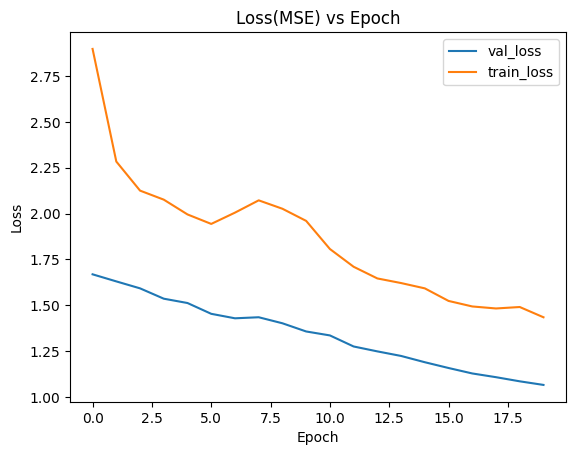

In [216]:
plt.plot(model.history.epoch, model.history.history['val_loss'], label = 'val_loss')
plt.plot(model.history.epoch, np.array(model.history.history['loss']), label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss(MSE) vs Epoch')
plt.legend()
plt.show()

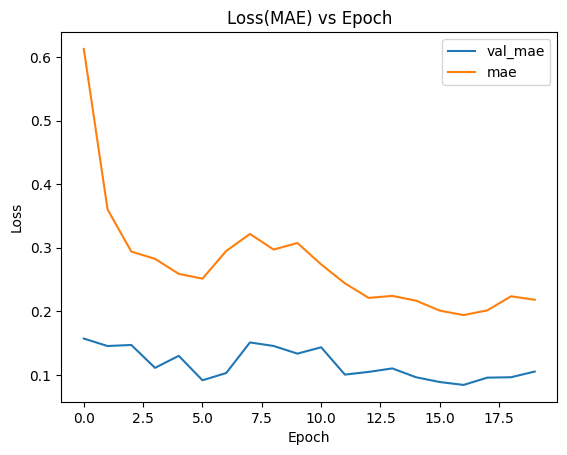

In [218]:
plt.plot(model.history.epoch, model.history.history['val_mae'], label='val_mae')
plt.plot(model.history.epoch, np.array(model.history.history['mae']), label='mae')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss(MAE) vs Epoch')
plt.legend()
plt.show()

## Testing

In [40]:
model_path = "XRay_JointDetection/checkpoints/model_checkpoint_working.h5"
model.load_weights(model_path)

In [184]:
test_image_path = "XRay_JointDetection/Dataset/9374775.png"

In [185]:
test_image = cv2.imread(test_image_path)

In [186]:
def preprocess_image(file_path, label):
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=1)
    
    img.set_shape([None, None, 1])
    # Resize the image to the desired dimensions (e.g., 224x224)
    img = tf.image.resize(img, [224, 224])
#     # Convert the pixel values to the range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img/255.
    
    return img, label

In [187]:
img, _ = preprocess_image(test_image_path, "")

In [188]:
img = tf.expand_dims(img, axis=0)

In [189]:
output = model.predict(img)
output

1/1 [==============================] - 0s 16ms/step


array([[[ 0.32472655,  0.30830997,  0.31599113,  0.42344704,
          0.4296489 ,  0.44067398,  0.49119887,  0.50607485,
          0.5117748 ,  0.544065  ,  0.6116682 ,  0.6291111 ],
        [ 0.58366287,  0.39552468,  0.29228392,  0.57104   ,
          0.39174372,  0.2601755 ,  0.6054252 ,  0.44324365,
          0.31856695,  0.6497289 ,  0.528504  ,  0.4479419 ],
        [-0.07174449, -0.16840427, -0.00393981, -0.20579633,
          0.04262293,  0.17934005,  0.1942392 ,  0.29873073,
          0.2901328 ,  0.49642932,  0.48255798,  0.46451083]]],
      dtype=float32)

In [190]:
image_x, image_y, _ = test_image.shape

In [191]:
image_x, image_y

(2570, 2040)

In [192]:
x_cords = output[0][0]*image_x
y_cords = output[0][1]*image_y
r_vals = output[0][2]

In [193]:
box_points = []
for i in range(0,12):
    box_points += [(x_cords[i], y_cords[i], r_vals[i])]

box_points

[(874.5472412109375, 1230.6722412109375, -0.07174449),
 (832.3566284179688, 846.870361328125, -0.16840427),
 (852.0972290039062, 636.2592163085938, -0.0039398097),
 (1128.2589111328125, 1204.9215087890625, -0.20579633),
 (1144.1976318359375, 839.1571655273438, 0.042622928),
 (1172.5321044921875, 570.7579956054688, 0.17934005),
 (1302.381103515625, 1275.0673828125, 0.1942392),
 (1340.6123046875, 944.217041015625, 0.29873073),
 (1355.26123046875, 689.8765869140625, 0.2901328),
 (1438.2470703125, 1365.4468994140625, 0.49642932),
 (1611.9873046875, 1118.148193359375, 0.48255798),
 (1656.8155517578125, 953.8014526367188, 0.46451083)]

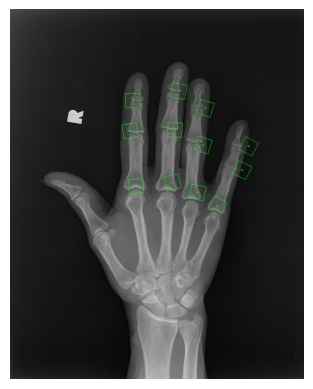

In [194]:
import cv2
import numpy as np

# Function to draw a rotated square
def draw_rotated_square(image, center, angle_rad, side_length, color=(0, 255, 0), thickness=2):
    # Calculate the four corners of the rotated square
    
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    half_length = side_length / 2
    x1 = int(center[0] - half_length * cos_a - half_length * sin_a)
    y1 = int(center[1] - half_length * sin_a + half_length * cos_a)
    x2 = int(center[0] + half_length * cos_a - half_length * sin_a)
    y2 = int(center[1] + half_length * sin_a + half_length * cos_a)
    x3 = int(2 * center[0] - x1)
    y3 = int(2 * center[1] - y1)
    x4 = int(2 * center[0] - x2)
    y4 = int(2 * center[1] - y2)

    # Draw the rotated square
    points = np.array([[x1, y1], [x2, y2],[x3, y3], [x4, y4]], np.int32)
    points = points.reshape((-1, 1, 2))
    
    cv2.circle(image, center, 5, color, thickness=thickness)
    cv2.polylines(image, [points], isClosed=True, color=color, thickness=thickness)


for box_x, box_y, radian in box_points:

    # Center coordinates
    center = (int(box_x), int(box_y))

    # Side length of the square
    side_length = 100

    # Draw the rotated square on the image
    draw_rotated_square(test_image, center, radian, side_length)

cv2.startWindowThread()
# Display the image
cv2.imshow("Rotated Square", test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Display the image
plt.imshow(test_image)
plt.axis('off')  # Turn off axis labels
plt.show()
